In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [2]:
# Load datasets
raw_data1 = pd.read_csv('../dataset/GP1_0.6_force.csv')
raw_data2 = pd.read_csv('../dataset/GP1_0.7_force.csv')
raw_data3 = pd.read_csv('../dataset/GP1_0.8_force.csv')

# Assign labels
raw_data1['gait_phase'] = 'Slow'
raw_data2['gait_phase'] = 'Medium'
raw_data3['gait_phase'] = 'Fast'

# Combine datasets
data = pd.concat([raw_data1, raw_data2, raw_data3], axis=0).reset_index(drop=True)

# Display data
print(data['gait_phase'].value_counts())
data.head()


gait_phase
Slow      60000
Medium    60000
Fast      60000
Name: count, dtype: int64


,FP1_x,FP2_x,FP1_y,FP2_y,FP1_z,FP2_z,gait_phase
0,0.0,-9.537293,0.0,30.241894,0.0,777.790222,Slow
1,0.0,-8.993257,0.0,30.251348,0.0,777.832886,Slow
2,0.0,-8.459884,0.0,30.250864,0.0,777.852966,Slow
3,0.0,-7.937055,0.0,30.241360,0.0,777.852539,Slow
4,0.0,-7.424666,0.0,30.223719,0.0,777.833374,Slow


### Data Preparation

In [3]:
# Separate features and labels
X = data.drop(columns=['gait_phase'])
y = data['gait_phase']

# Encode labels into numerical format
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

# data shapes
print("Training Features Shape:", X_train.shape)
print("Testing Features Shape:", X_test.shape)
print("Training Labels Shape:", y_train.shape)
print("Testing Labels Shape:", y_test.shape)


Training Features Shape: (126000, 6)
Testing Features Shape: (54000, 6)
Training Labels Shape: (126000,)
Testing Labels Shape: (54000,)


In [4]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [5]:
# train MLPClassifier
mlp = MLPClassifier(
    solver='adam',
    hidden_layer_sizes=(200, 100, 55),
    activation='tanh',
    max_iter=50,
    verbose=True
)

mlp.fit(X_train_scaled, y_train)


Iteration 1, loss = 1.02521279
Iteration 2, loss = 0.90379969
Iteration 3, loss = 0.85416419
Iteration 4, loss = 0.82703566
Iteration 5, loss = 0.81134510
Iteration 6, loss = 0.79739303
Iteration 7, loss = 0.78568550
Iteration 8, loss = 0.77551917
Iteration 9, loss = 0.76562991
Iteration 10, loss = 0.76032501
Iteration 11, loss = 0.74847712
Iteration 12, loss = 0.74131205
Iteration 13, loss = 0.73171617
Iteration 14, loss = 0.72359920
Iteration 15, loss = 0.71332703
Iteration 16, loss = 0.70509795
Iteration 17, loss = 0.69245084
Iteration 18, loss = 0.68285103
Iteration 19, loss = 0.67518859
Iteration 20, loss = 0.66357095
Iteration 21, loss = 0.65207363
Iteration 22, loss = 0.64137649
Iteration 23, loss = 0.62946712
Iteration 24, loss = 0.61747873
Iteration 25, loss = 0.60729738
Iteration 26, loss = 0.59711807
Iteration 27, loss = 0.58925218
Iteration 28, loss = 0.57766794
Iteration 29, loss = 0.56824020
Iteration 30, loss = 0.56082476
Iteration 31, loss = 0.55342892
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='tanh', hidden_layer_sizes=(200, 100, 55), max_iter=50,
              verbose=True)

In [6]:
# Evaluate MLPClassifier
mlp_pred = mlp.predict(X_test_scaled)
mlp_accuracy = accuracy_score(y_test, mlp_pred)
print("MLPClassifier Accuracy:", mlp_accuracy)


MLPClassifier Accuracy: 0.7728703703703703


### saving model

In [11]:
import joblib

# Save the MLPClassifier model to a file
model_filename = "mlp_classifier_model.joblib"
joblib.dump(mlp, model_filename)
print(f"Model saved to {model_filename}")


Model saved to mlp_classifier_model.joblib


### importing the saved model

In [12]:
# Load the saved model
loaded_model = joblib.load(model_filename)
print("Model loaded successfully!")

# Example: Predict using the loaded model
new_data = X_test_scaled[:5]  # Use some test data for demonstration
predictions = loaded_model.predict(new_data)

# Decode the predictions to their original class names
predicted_classes = label_encoder.inverse_transform(predictions)

print("Predictions:", predicted_classes)


Model loaded successfully!
Predictions: ['Fast' 'Slow' 'Slow' 'Slow' 'Medium']


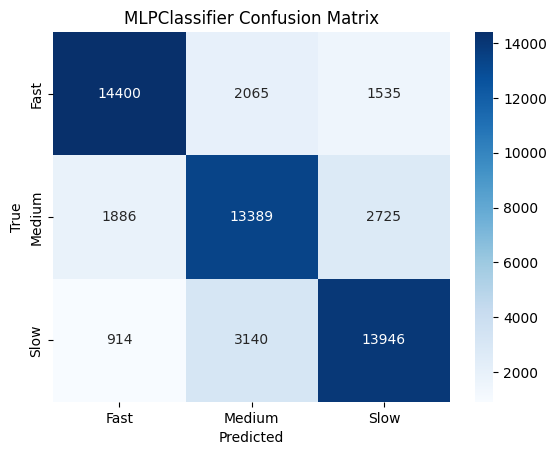

In [7]:
# Confusion Matrix for MLPClassifier
mlp_conf_matrix = confusion_matrix(y_test, mlp_pred)
sns.heatmap(mlp_conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("MLPClassifier Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

### Train a Deep Learning Model for benchmarking

In [8]:
# Convert labels to categorical format for Keras
y_train_categorical = to_categorical(y_train, num_classes=len(np.unique(y_train)))
y_test_categorical = to_categorical(y_test, num_classes=len(np.unique(y_test)))

# Deep Learning Model
dl_model = Sequential([
    Dense(256, input_dim=X_train_scaled.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(len(np.unique(y_train)), activation='softmax')
])

# Compile
dl_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = dl_model.fit(X_train_scaled, y_train_categorical, validation_split=0.2, epochs=50, batch_size=32, verbose=1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.4345 - loss: 1.0375 - val_accuracy: 0.5523 - val_loss: 0.8955
Epoch 2/50
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.5361 - loss: 0.9103 - val_accuracy: 0.5815 - val_loss: 0.8428
Epoch 3/50
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.5697 - loss: 0.8601 - val_accuracy: 0.6061 - val_loss: 0.7958
Epoch 4/50
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.5782 - loss: 0.8397 - val_accuracy: 0.6004 - val_loss: 0.7999
Epoch 5/50
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.5829 - loss: 0.8302 - val_accuracy: 0.6157 - val_loss: 0.7734
Epoch 6/50
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.5893 - loss: 0.8180 - val_accuracy: 0.6015 - val_loss: 0.7807
Epoch 7/50
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.5941 - loss: 0.8083 - val_accuracy: 0.6095 - val_loss: 0.7711
Epoch 8/50
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.5997 - loss: 0.

In [9]:
# Evaluate Deep Learning Model
dl_loss, dl_accuracy = dl_model.evaluate(X_test_scaled, y_test_categorical, verbose=0)
print("Deep Learning Model Accuracy:", dl_accuracy)


Deep Learning Model Accuracy: 0.7212777733802795


1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


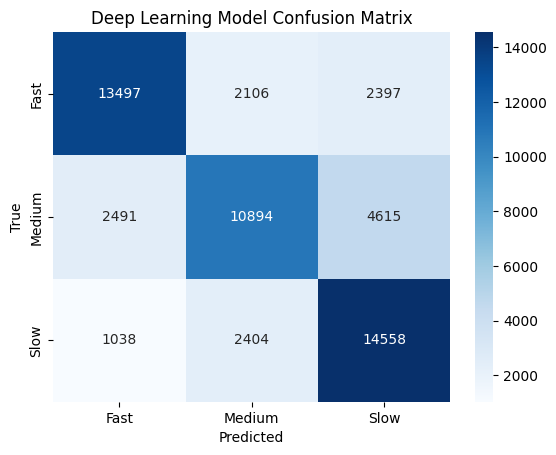

In [10]:
# Confusion Matrix for Deep Learning Model
dl_pred = np.argmax(dl_model.predict(X_test_scaled), axis=1)
dl_conf_matrix = confusion_matrix(y_test, dl_pred)
sns.heatmap(dl_conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Deep Learning Model Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()